# 1. Import the Data
Import the individual image files; this will take some time!

In [1]:
# Build a list of images using a for loop
import pandas as pd
import numpy as np
import requests
from PIL import Image
import io
import tensorflow as tf
from tensorflow.keras import layers, models, Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# Define the base_url
path = "https://static.bc-edx.com/ai/ail-v-1-0/m19/lesson_3/datasets/csvs/files_list.csv"

# Import the file and display the first few rows
filenames_df = pd.read_csv(path)
filenames_df.head()

,files
0,ch4f_straight_angry_sunglasses.png
1,tammo_straight_neutral_sunglasses.png
2,at33_straight_neutral_open.png
3,boland_up_angry_open.png
4,mitchell_straight_angry_sunglasses.png


In [2]:
# Define the base_url
base_url = "https://static.bc-edx.com/ai/ail-v-1-0/m19/lesson_3/datasets/faces_data/"

# Create an empty list for the urls
img_urls = []

# Loop through the DataFrame and build and append the full image urls
for i in range(len(filenames_df)):
    filename = filenames_df.iloc[i,0]
    img_urls.append(base_url + filename)

img_urls[0:5]

['https://static.bc-edx.com/ai/ail-v-1-0/m19/lesson_3/datasets/faces_data/ch4f_straight_angry_sunglasses.png',
 'https://static.bc-edx.com/ai/ail-v-1-0/m19/lesson_3/datasets/faces_data/tammo_straight_neutral_sunglasses.png',
 'https://static.bc-edx.com/ai/ail-v-1-0/m19/lesson_3/datasets/faces_data/at33_straight_neutral_open.png',
 'https://static.bc-edx.com/ai/ail-v-1-0/m19/lesson_3/datasets/faces_data/boland_up_angry_open.png',
 'https://static.bc-edx.com/ai/ail-v-1-0/m19/lesson_3/datasets/faces_data/mitchell_straight_angry_sunglasses.png']

0/624: Attempting to import https://static.bc-edx.com/ai/ail-v-1-0/m19/lesson_3/datasets/faces_data/ch4f_straight_angry_sunglasses.png
1/624: Attempting to import https://static.bc-edx.com/ai/ail-v-1-0/m19/lesson_3/datasets/faces_data/tammo_straight_neutral_sunglasses.png
2/624: Attempting to import https://static.bc-edx.com/ai/ail-v-1-0/m19/lesson_3/datasets/faces_data/at33_straight_neutral_open.png
3/624: Attempting to import https://static.bc-edx.com/ai/ail-v-1-0/m19/lesson_3/datasets/faces_data/boland_up_angry_open.png
4/624: Attempting to import https://static.bc-edx.com/ai/ail-v-1-0/m19/lesson_3/datasets/faces_data/mitchell_straight_angry_sunglasses.png
5/624: Attempting to import https://static.bc-edx.com/ai/ail-v-1-0/m19/lesson_3/datasets/faces_data/kk49_straight_neutral_sunglasses.png
6/624: Attempting to import https://static.bc-edx.com/ai/ail-v-1-0/m19/lesson_3/datasets/faces_data/choon_left_sad_open.png
7/624: Attempting to import https://static.bc-edx.com/ai/ail-v-1-0/m19/

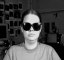

In [3]:
# Create and empty list for images
imgs = []

# Loop through ALL image_urls to open and append each image
num_imgs = len(img_urls)

for i in range(num_imgs):
    img_url = img_urls[i]
    # Print a statement to show progress
    print(f"{i}/{num_imgs}: Attempting to import {img_url}")

    # Use requests.get along with the stream parameter and raw attribute
    response = requests.get(img_url, stream=True).raw

    # Append each img to the imgs list
    imgs.append(Image.open(response))

# View the first image to confirm
imgs[0]

# 2. Preprocessing Images
Resize, convert to floating point, and normalize. If you'd like a challenge, research mean subtraction or standard deviation scaling!

In [4]:
# Get all the sizes into a list, then convert to a set
sizes = set([img.size for img in imgs])
sizes

{(32, 30), (64, 60), (128, 120)}

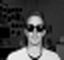

In [5]:
# Convert the images to the middle 64, 60 size

target_size = (64, 60)
resized_imgs = [img.resize(target_size, resample = Image.LANCZOS) for img in imgs]
resized_imgs[1]

In [6]:
# Convert all images to floating point numpy arrays
float_images = [np.array(img).astype(np.float32) for img in resized_imgs]

# Display the pixel values of the first image
print("Pixel Values:")
print(float_images[0])

Pixel Values:
[[21. 19. 19. ... 45. 45. 43.]
 [47. 43. 33. ... 45. 45. 45.]
 [64. 66. 75. ... 45. 45. 43.]
 ...
 [50. 43. 40. ...  0.  0.  0.]
 [49. 43. 33. ...  0.  0.  0.]
 [49. 47. 33. ... 29.  0.  0.]]


In [7]:
# To normalize pixel values to a range between 0 and 1,
# we need to divide all pixel values by the max of 255

normalized_images = [img/255 for img in float_images]

# Display the pixel values of the first image
print("Pixel Values:")
print(normalized_images[0])

Pixel Values:
[[0.08235294 0.07450981 0.07450981 ... 0.1764706  0.1764706  0.16862746]
 [0.18431373 0.16862746 0.12941177 ... 0.1764706  0.1764706  0.1764706 ]
 [0.2509804  0.25882354 0.29411766 ... 0.1764706  0.1764706  0.16862746]
 ...
 [0.19607843 0.16862746 0.15686275 ... 0.         0.         0.        ]
 [0.19215687 0.16862746 0.12941177 ... 0.         0.         0.        ]
 [0.19215687 0.18431373 0.12941177 ... 0.11372549 0.         0.        ]]


Lets look at our filename data and prepare it for the model.

In [8]:
# Look at the filenames DataFrame
filenames_df.head()

,files
0,ch4f_straight_angry_sunglasses.png
1,tammo_straight_neutral_sunglasses.png
2,at33_straight_neutral_open.png
3,boland_up_angry_open.png
4,mitchell_straight_angry_sunglasses.png


In [9]:
# First, remove the .png file extension, then split into four new columns.
filenames_df[['userid', 'pose', 'expression', 'eyes']] = filenames_df['files']\
                                                            .str.replace('.png', '', regex=False)\
                                                            .str.split('_', expand=True)

# Make a new df without the "files" column
y_df = filenames_df[['userid', 'pose', 'expression', 'eyes']].copy()
y_df.head()

,userid,pose,expression,eyes
0,ch4f,straight,angry,sunglasses
1,tammo,straight,neutral,sunglasses
2,at33,straight,neutral,open
3,boland,up,angry,open
4,mitchell,straight,angry,sunglasses


Now that we've split our y data into separate columns, lets preprocess each y column and determine how many output layers to create.

In [10]:
# Start with the userid column
# Look at the value counts to decide which encoder to use
y_df['userid'].value_counts()

userid
ch4f        32
saavik      32
cheyer      32
steffi      32
an2i        32
bpm         32
night       32
kk49        32
boland      32
at33        32
choon       31
danieln     31
phoebe      31
sz24        31
karyadi     31
kawamura    31
megak       30
tammo       30
glickman    30
mitchell    28
Name: count, dtype: int64

In [11]:
# OneHotEncode the userid column
# Create an encoder
userid_encoder = OneHotEncoder(sparse_output=False)

# Fit_transform the userid column
userid_encoded = userid_encoder.fit_transform(y_df[['userid']])

# Get the feature names from the encoder
userid_columns = userid_encoder.get_feature_names_out(['userid'])

# Create a new DataFrame with the data
userid_encoded_df = pd.DataFrame(userid_encoded, columns=userid_columns)

# View the first few rows of the data
userid_encoded_df.head()

,userid_an2i,userid_at33,userid_boland,userid_bpm,userid_ch4f,userid_cheyer,userid_choon,userid_danieln,userid_glickman,userid_karyadi,userid_kawamura,userid_kk49,userid_megak,userid_mitchell,userid_night,userid_phoebe,userid_saavik,userid_steffi,userid_sz24,userid_tammo
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
# Repeat the process for the pose column
# Look at the value counts to decide which encoder to use
y_df['pose'].value_counts()

pose
left        157
straight    156
up          156
right       155
Name: count, dtype: int64

In [13]:
# Create an encoder
pose_encoder = OneHotEncoder(sparse_output=False)

# Fit_transform the pose column
pose_encoded = pose_encoder.fit_transform(y_df[['pose']])

# Get the feature names from the encoder
pose_columns = pose_encoder.get_feature_names_out(['pose'])

# Create a new DataFrame with the data
pose_encoded_df = pd.DataFrame(pose_encoded, columns=pose_columns)

# View the first few rows of the data
pose_encoded_df.head()

,pose_left,pose_right,pose_straight,pose_up
0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0
4,0.0,0.0,1.0,0.0


In [14]:
# Repeat the process for the expression column
# Start with the userid column
# Look at the value counts to decide which encoder to use
y_df['expression'].value_counts()

expression
neutral    158
sad        156
angry      155
happy      155
Name: count, dtype: int64

In [15]:
# Create an encoder
expression_encoder = OneHotEncoder(sparse_output=False)

# Fit_transform the expression column
expression_encoded = expression_encoder.fit_transform(y_df[['expression']])

# Get the feature names from the encoder
expression_columns = expression_encoder.get_feature_names_out(['expression'])

# Create a new DataFrame with the data
expression_encoded_df = pd.DataFrame(expression_encoded, columns=expression_columns)

# View the first few rows of the data
expression_encoded_df.head()

,expression_angry,expression_happy,expression_neutral,expression_sad
0,1.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0


In [16]:
# Repeat the process for the eyes column
# Start with the userid column
# Look at the value counts to decide which encoder to use
y_df['eyes'].value_counts()

eyes
open          313
sunglasses    311
Name: count, dtype: int64

In [17]:
# Create an encoder
eyes_encoder = OneHotEncoder(sparse_output=False, drop='first')

# Fit_transform the eyes column
eyes_encoded = eyes_encoder.fit_transform(y_df[['eyes']])

# Get the feature names from the encoder
eyes_columns = eyes_encoder.get_feature_names_out(['eyes'])

# Create a new DataFrame with the data
eyes_encoded_df = pd.DataFrame(eyes_encoded, columns=eyes_columns)

# View the first few rows of the data
eyes_encoded_df.head()

,eyes_sunglasses
0,1.0
1,1.0
2,0.0
3,0.0
4,1.0


In [18]:
# Combine the processed y data into a new DataFrame
y_processed_df = pd.concat([
    userid_encoded_df,
    pose_encoded_df,
    expression_encoded_df,
    eyes_encoded_df
    ],
    axis=1
    )

# Display the first few rows
y_processed_df.head()

,userid_an2i,userid_at33,userid_boland,userid_bpm,userid_ch4f,userid_cheyer,userid_choon,userid_danieln,userid_glickman,userid_karyadi,...,userid_tammo,pose_left,pose_right,pose_straight,pose_up,expression_angry,expression_happy,expression_neutral,expression_sad,eyes_sunglasses
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


# 4. Augmenting the Image Files
When augmenting, it is important to think through whether any particular augmentation will invalidate a label. For instance, in this dataset, the "pose" label is dependent on the direction the subject is facing. If we flip an image horizontally, the "pose" label may be incorrect on the augmented file! Lets choose carefully which augmentations we can apply to this set.

In [19]:
# Convert X to a numpy array
X = np.array(normalized_images)

# Loop through each image to include the channel dimension
X_processed = []
for img in X:
    # Add channel dimension
    img = np.expand_dims(img, axis=-1)

    # Append the image to the array
    X_processed.append(img)

# Split X and y into train and test sets; do not augment the test set!
X_train, X_test, y_train, y_test = train_test_split(X_processed, y_processed_df)

In [20]:
import pickle

# Augment the images
# Define the augmentation pipeline
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.2),         # Random rotation (20 degrees)
    tf.keras.layers.RandomTranslation(0.1, 0.1), # Random horizontal and vertical shift
    tf.keras.layers.RandomZoom(0.2),             # Random zoom
    tf.keras.layers.RandomFlip('horizontal')     # Random horizontal flip
])

# Create an empty list to hold the augmented images
X_train_aug = []

# Create an empty DataFrame to hold the new y training data
# Use the column names from the processed y DataFrame
y_train_aug = pd.DataFrame(columns=y_processed_df.columns)

# Loop through the images
for i in range(len(X_train)):
    # Select the image
    img = X_train[i]

    # Select the label row from the y data
    label = y_train.iloc[[i]]

    # Add the batch dimension
    img = np.expand_dims(img, axis=0)

    # Add 5 new images for each original
    for j in range(5):
        # Append the image and the label
        X_train_aug.append(data_augmentation(img, training=True)[0].numpy())
        y_train_aug = pd.concat([y_train_aug, label]).reset_index(drop=True)

print(len(X_train_aug))
print(len(y_train_aug))


2340
2340


In [21]:
# Convert X_train_aug and X_test to numpy arrays
X_train_aug = np.array(X_train_aug)
X_test = np.array(X_test)

print(X_train_aug.shape)
print(X_test.shape)

(2340, 60, 64, 1)
(156, 60, 64, 1)


In [22]:
# Look at the first few rows of y_train_aug
y_train_aug.head()

,userid_an2i,userid_at33,userid_boland,userid_bpm,userid_ch4f,userid_cheyer,userid_choon,userid_danieln,userid_glickman,userid_karyadi,...,userid_tammo,pose_left,pose_right,pose_straight,pose_up,expression_angry,expression_happy,expression_neutral,expression_sad,eyes_sunglasses
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0


# 5. Preparing y Data for Output Layers
Now that we have all the y data formatted correctly, we need to divide it back into sets of columns that can be predicted by a single layer. For instance, all the userid columns should be together. It is perfectly reasonable to gather all onehotencoded outputs for the original columns back together and use 'sigmoid' as the activation function for all the output layers. This will result in one y variable for "userid", one for "expression", one for "pose" and one for "eyes".

Could any of these be combined? Would there be an advantage to using softmax instead of sigmoid somewhere?

Specifically for the userid column, what if we later use this model to predict an image of a new person? With sigmoid, all predictions would be forced to add to 1 even if the model was certain that the new image didn't belong to any of the original faces. With softmax, our model would be allowed to show a confidence near zero for every userid.

In [23]:
# Using a creative list comprehension, we can easily gather
# columns related to the userid in the training data
y_train_userid = y_train_aug[[col for col in y_train_aug.columns if 'userid' in col]]

# Repeat this for the following in the training data
# pose
y_train_pose = y_train_aug[[col for col in y_train_aug.columns if 'pose' in col]]

# expression
y_train_expression = y_train_aug[[col for col in y_train_aug.columns if 'expression' in col]]

# eyes
y_train_eyes = y_train_aug[[col for col in y_train_aug.columns if 'eyes' in col]]

# Now repeat all 4 selections with the y_test data
y_test_userid = y_test[[col for col in y_test.columns if 'userid' in col]]
y_test_pose = y_test[[col for col in y_test.columns if 'pose' in col]]
y_test_expression = y_test[[col for col in y_test.columns if 'expression' in col]]
y_test_eyes = y_test[[col for col in y_test.columns if 'eyes' in col]]

In [24]:
# Display the first few rows of one of the DataFrames to confirm your work
y_train_pose.head()

,pose_left,pose_right,pose_straight,pose_up
0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,1.0


# 6. Export Pickle Files
At this stage, the data has been manipulated and cleaned an extensive amount. We're happy with how the data looks, so this is a good opportunity to create a "checkpoint". Lets save all our data variables in a pickle file so we don't have to repeat our preprocessing the next time we try to work with our model!

In [25]:
# Create a dictionary containing all the data
preprocessed_data = {
    'X_train': X_train_aug,
    'X_test': X_test,
    'y_train_userid': y_train_userid,
    'y_train_pose': y_train_pose,
    'y_train_expression': y_train_expression,
    'y_train_eyes': y_train_eyes,
    'y_test_userid': y_test_userid,
    'y_test_pose': y_test_pose,
    'y_test_expression': y_test_expression,
    'y_test_eyes': y_test_eyes
}

# Store the dictionary as a pickle file
from google.colab import drive
import pickle

drive.mount('/content/drive')

with open('/content/drive/My Drive/preprocessed_faces_data.pkl', 'wb') as file:
    pickle.dump(preprocessed_data, file)

Mounted at /content/drive
